# Customer segmentation

Customer segmentation for targeted marketing is one of the most vital applications of the clustering algorithm. Here, as a manager of the online store, you would want to group the customers into different clusters, so that you can make a customised marketing campaign for each of the group. You do not have any label in mind, such as good customer or bad customer. You want to just look at patterns in customer data and then try and find segments. This is where clustering techniques can help you with segmenting the customers. Clustering techniques use the raw data to form clusters based on common factors among various data points. This is exactly what will also be done in segmentation, where various people or products will be grouped together on the basis of similarities and differences between them.

 

As a manager, you would have to decide what the important business criteria are on which you would want to segregate the customers. So, you would need a method or an algorithm that itself decides which customers to group together based on this criteria.

successful segmentation, the segments formed must be stable. This means that the same person should not fall under different segments upon segmenting the data on the same criteria. You also saw that segments should have intra-segment homogeneity and inter-segment heterogeneity. 

In [1]:
#Importing Libraries
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
import seaborn as sns
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [2]:
#reading Dataset
retail = pd.read_csv("Online Retail.csv",  sep = ',',encoding = "ISO-8859-1", header= 0)

In [3]:
# parse date
#We are using infer_datetime_format=True to read parse the date data, this is slower than using a pre-defined format.
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'], infer_datetime_format=True)

In [4]:
#Sanity Check
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom


In [5]:
retail.shape

(541909, 8)

In [6]:
retail.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [7]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


# Preliminary data cleaning.

In [8]:
#Na Handling
retail.isnull().values.any()

True

In [9]:
#count the missing Values
retail.isnull().values.sum()

136534

In [10]:
#Calculate the percentage of Missing Values
retail.isnull().sum()*100/retail.shape[0]

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

In [11]:
#dropping the na cells
order_wise = retail.dropna()

In [12]:
#Sanity check
order_wise.shape
order_wise.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Our main objective is to cluster the customers of the online store. So, you need to transform this order-wise data into customer-wise data by finding key attributes that best characterises a customer. This is achieved through RFM analysis.

 

RFM analysis

In RFM analysis, you look at the recency, frequency and the monetary scores of all the customers for segmentation.

Recency: It measures how recently you visited the store or made a purchase

Frequency: It measures the frequency of the transactions the customers made

Monetary: It measures how much the customer spent on purchases he/she made

 

So, your target is to compute the RFM numbers for each customer, which effectively means that the granularity level of your data set will change from Invoice number to the CustomerID. Thus, you will have one unique row corresponding to each customer.

Let’s start with creating customer-wise data. We begin with the computation of M of the RFM, that is the total monetary value of the purchases made by each customer.

 

Create a vector named Amount, which creates the total monetary value of each order, and append the column to your data set.

In [13]:
#RFM implementation
#Monetary 
#create a new variables called amount
amount  = pd.DataFrame(order_wise.Quantity * order_wise.UnitPrice, columns = ["Amount"])

In [14]:
amount.head()

,Amount
0,15.30
1,20.34
2,22.00
3,20.34
4,20.34


In [15]:
#merging amount in order_wise
order_wise = pd.concat(objs = [order_wise, amount], axis = 1, ignore_index = False)


In [16]:
order_wise.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34


Now, sort the data set in order of CustomerID. Next, create a new vector — monetary — which gives the aggregated purchase amount for each customer.

This data frame monetary is the M of the RFM framework.

In [17]:
#Monetary Function
monetary = order_wise.groupby("CustomerID").Amount.sum()
monetary = monetary.reset_index()

In [18]:
monetary.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


Next, let’s compute the frequency of purchase for each customer, i.e. the F of the RFM framework. For this, you will count the number of unique Invoice Numbers for each Customer ID.  This is the “Frequency” corresponding to each customer.

In [19]:
#Frequency function
frequency = order_wise[['CustomerID', 'InvoiceNo']]

In [20]:
frequency.head()

,CustomerID,InvoiceNo
0,17850.0,536365
1,17850.0,536365
2,17850.0,536365
3,17850.0,536365
4,17850.0,536365


In [21]:
k = frequency.groupby("CustomerID").InvoiceNo.count()
k = pd.DataFrame(k)
k = k.reset_index()
k.columns = ["CustomerID", "Frequency"]
k.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


Finally, merge this data frame with the “Frequency” of each customer into your earlier data set containing the “Monetary” value.  

In [22]:
#creating master dataset
master = monetary.merge(k, on = "CustomerID", how = "inner")
master.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


Thus, the data frame master contains both the monetary and the frequency attributes corresponding to each customer IDs. Now, you have to turn your attention towards the computation of the recency, i.e. for how long a customer has not visited the online store.

Begin by extracting the Customer ID and Invoice Date from the data. Now, find the latest “Invoice Date” which forms the reference point for the calculation of the “Recency” of each customer. For each order corresponding to each customer, you find the difference from the latest “Invoice Date” and then find the minimum “Recency” value for each customer.

In [23]:
#Generating recency function
recency  = order_wise[['CustomerID','InvoiceDate']]


In [24]:
recency.head()

,CustomerID,InvoiceDate
0,17850.0,2010-01-12 08:26:00
1,17850.0,2010-01-12 08:26:00
2,17850.0,2010-01-12 08:26:00
3,17850.0,2010-01-12 08:26:00
4,17850.0,2010-01-12 08:26:00


In [25]:
maximum = max(recency.InvoiceDate)
maximum = maximum + pd.DateOffset(days=1)
recency['diff'] = maximum - recency.InvoiceDate
recency.head()

C:\Users\Uday\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,CustomerID,InvoiceDate,diff
0,17850.0,2010-01-12 08:26:00,698 days 08:53:00
1,17850.0,2010-01-12 08:26:00,698 days 08:53:00
2,17850.0,2010-01-12 08:26:00,698 days 08:53:00
3,17850.0,2010-01-12 08:26:00,698 days 08:53:00
4,17850.0,2010-01-12 08:26:00,698 days 08:53:00


In [26]:
#Dataframe merging by recency
df = pd.DataFrame(recency.groupby('CustomerID').diff.min())
df = df.reset_index()
df.columns = ["CustomerID", "Recency"]
df.head()

,CustomerID,Recency
0,12346.0,327 days 07:02:00
1,12347.0,41 days 04:54:00
2,12348.0,77 days 04:06:00
3,12349.0,20 days 07:28:00
4,12350.0,312 days 01:18:00


Now, the data frame recency contains the recency for each customer. Let’s merge it to the RFM data set and change the format to the required form.

In [27]:
#Combining all recency, frequency and monetary parameters
RFM = k.merge(monetary, on = "CustomerID")
RFM = RFM.merge(df, on = "CustomerID")
RFM.head()

,CustomerID,Frequency,Amount,Recency
0,12346.0,2,0.00,327 days 07:02:00
1,12347.0,182,4310.00,41 days 04:54:00
2,12348.0,31,1797.24,77 days 04:06:00
3,12349.0,73,1757.55,20 days 07:28:00
4,12350.0,17,334.40,312 days 01:18:00


Thus, you have obtained the RFM data corresponding to each customer. These 3 attributes will form the basis, depending on which the customers will be segregated into different clusters.

However, your data preparation is still not complete. You have already seen previously how the clustering process can be impacted due to the presence of outliers. So, let’s treat the data set for outliers. One way to do it is by eliminating all the data points which fall outside the 1.5 times the IQR of the 1st and the 3rd quartile.

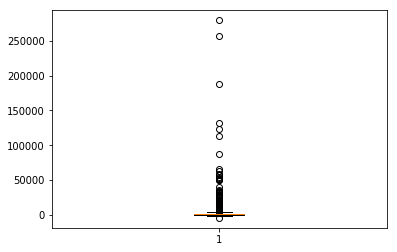

In [28]:
# outlier treatment for Amount
plt.boxplot(RFM.Amount)
Q1 = RFM.Amount.quantile(0.25)
Q3 = RFM.Amount.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Amount >= Q1 - 1.5*IQR) & (RFM.Amount <= Q3 + 1.5*IQR)]

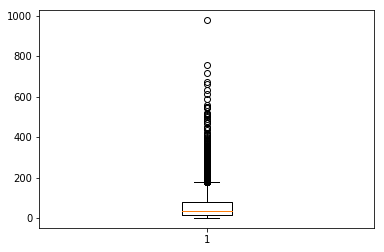

In [29]:
# outlier treatment for Frequency
plt.boxplot(RFM.Frequency)
Q1 = RFM.Frequency.quantile(0.25)
Q3 = RFM.Frequency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Frequency >= Q1 - 1.5*IQR) & (RFM.Frequency <= Q3 + 1.5*IQR)]

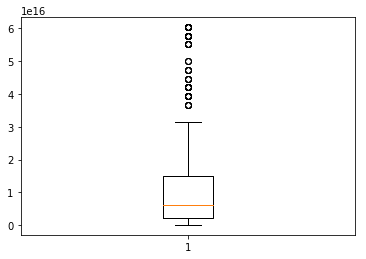

In [30]:
# outlier treatment for Recency
plt.boxplot(RFM.Recency)
Q1 = RFM.Recency.quantile(0.25)
Q3 = RFM.Recency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Recency >= Q1 - 1.5*IQR) & (RFM.Recency <= Q3 + 1.5*IQR)]

In [31]:
RFM.head(20)

,CustomerID,Frequency,Amount,Recency
0,12346.0,2,0.00,327 days 07:02:00
2,12348.0,31,1797.24,77 days 04:06:00
3,12349.0,73,1757.55,20 days 07:28:00
4,12350.0,17,334.40,312 days 01:18:00
5,12352.0,95,1545.41,74 days 02:21:00
6,12353.0,4,89.00,205 days 23:32:00
7,12354.0,58,1079.40,234 days 04:08:00
8,12355.0,13,459.40,97 days 03:30:00
9,12356.0,59,2811.43,24 days 08:39:00
11,12358.0,19,1168.06,4 days 07:15:00


In [32]:
# standardise all parameters
RFM_norm1 = RFM.drop("CustomerID", axis=1)
RFM_norm1.Recency = RFM_norm1.Recency.dt.days

In [33]:
RFM_norm1.Recency.head()

0    327
2     77
3     20
4    312
5     74
Name: Recency, dtype: int64

So, the data preparation is now complete. So, let’s reiterate the steps involved in data preparation:

Missing value treatment

Transforming data from Order-level to Customer-level

Calculation of RFM values

Outlier treatment

Standardisation of data

The major practical considerations involved in K-Means clustering are:

The number of clusters that you want to divide your data points into, i.e. the value of K has to be pre-determined.

The choice of the initial cluster centres can have an impact on the final cluster formation.

The clustering process is very sensitive to the presence of outliers in the data.

Since the distance metric used in the clustering process is the Euclidean distance, you need to bring all your attributes on the same scale. This can be achieved through standardisation.

The K-Means algorithm does not work with categorical data.

The process may not converge in the given number of iterations. You should always check for convergence.

In [34]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
standard_scaler.fit_transform(RFM_norm1)

C:\Users\Uday\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Uday\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([[-1.08205673, -1.0557058 ,  2.33176413],
       [-0.38875763,  1.36528882, -0.28560604],
       [ 0.61533072,  1.31182391, -0.88236644],
       ...,
       [-0.9625224 , -0.9468362 , -1.03940866],
       [-0.81908121, -0.81781456, -0.10762487],
       [ 0.54361012,  1.41922521, -1.08128658]])

business constraints are one of the factors that help decide the value of K. However, there is a mathematical route as well to arrive at the optimal value of K. This is done through the elbow curve method.

 

You have seen earlier that KMeans() stores the sum of the squared distance of the points to their respective clusters centres as inertia. In other words, inertia represents, how tightly the different clusters are formed. As we increase the number of clusters, the inertia value is bound to decrease as the individual clusters become more compact. Thus, the plot of inertia against the number of clusters becomes a monotonically decreasing plot.

 

However, in this plot (Fig 1), you can notice a distinct elbow. Beyond the elbow point, the additional (marginal) decrease in inertia with each increase in the cluster number is not very prominent. Thus, the elbow in the curve gives an estimate of the optimal number K in K Means.

Now let's implement the elbow curve method to see what would be the optimal number of K in our case. We would use a loop to store the inertia value while changing the value of K from 1 to 21.

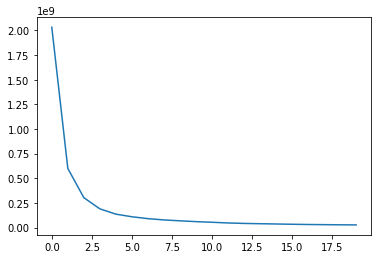

In [35]:
# sum of squared distances
ssd = []
for num_clusters in list(range(1,21)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(RFM_norm1)
    ssd.append(model_clus.inertia_)

plt.plot(ssd)

In [36]:
model_clus5 = KMeans(n_clusters = 5, max_iter=50)
model_clus5.fit(RFM_norm1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

n_clusters: The number of clusters to form as well as the number of centroids to generate
init: Method for initialization of the cluster centres
n_init: Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia (explained below).
max_iter: Maximum number of iterations of the k-means algorithm for a single run in case it doesn't converge on its own

The algorithm begins with choosing K random cluster centres.

 

Then the 2 steps of Assignment and Optimisation continue iteratively till the clusters stop updating. This gives you the most optimal clusters — the clusters with minimum intra-cluster distance and maximum inter-cluster distance.

 

You also saw the different practical issues that need to be considered while employing clustering to your data set. You need to choose how many clusters you want to group your data points into. Secondly, the K-means algorithm is non-deterministic. This means that the final outcome of clustering can be different each time the algorithm is run even on the same data set. This is because, as you saw, the final cluster that you get can vary by the choice of the initial cluster centres.

 

You also saw that the outliers have an impact on the clusters and thus outlier-infested data may not give you the most optimal clusters. Similarly, since the most common measure of the distance is the Euclidean distance, you would need to bring all the attributes into the same scale using standardisation.

In [37]:
# analysis of clusters formed
RFM.index = pd.RangeIndex(len(RFM.index))
RFM_km = pd.concat([RFM, pd.Series(model_clus5.labels_)], axis=1)
RFM_km.columns = ['CustomerID', 'Frequency', 'Amount', 'Recency', 'ClusterID']

RFM_km.Recency = RFM_km.Recency.dt.days
km_clusters_amount = 	pd.DataFrame(RFM_km.groupby(["ClusterID"]).Amount.mean())
km_clusters_frequency = 	pd.DataFrame(RFM_km.groupby(["ClusterID"]).Frequency.mean())
km_clusters_recency = 	pd.DataFrame(RFM_km.groupby(["ClusterID"]).Recency.mean())

In [42]:
RFM_km.head(20)

,CustomerID,Frequency,Amount,Recency,ClusterID
0,12346.0,2,0.00,327,0
1,12348.0,31,1797.24,77,2
2,12349.0,73,1757.55,20,2
3,12350.0,17,334.40,312,0
4,12352.0,95,1545.41,74,3
5,12353.0,4,89.00,205,0
6,12354.0,58,1079.40,234,3
7,12355.0,13,459.40,97,4
8,12356.0,59,2811.43,24,1
9,12358.0,19,1168.06,4,3


Let's now try to understand the output of the KMeans() function.

cluster_centers: Coordinates of cluster centres
labels: Labels of each point i.e. the labels to which the points belong
inertia: Sum of squared distances of points to their closest cluster centre
Now the question arises, how do we really decide the number of cluster centres or in other words, the value of K in the K-Means algorithm?

Interpreting the Result
In the last segment, you saw how to find the most optimal value K. However, one step of the same involved analysing the obtained clusters from the business point of view. Let’s see how to proceed with the analysis of the obtained clusters by taking K = 5 for our further analysis.

Thus, you obtained the ClusterID corresponding to each CustomerID from the kmeans() function. These ClusterIDs were appended to the original RFM data set which had the Recency, Frequency and the Monetary values corresponding to each CustomerID.

 

Then, we aggregated the mean value for Recency, Frequency and the Monetary value for each of the cluster group. This helped you profile each of the obtained 5 clusters.

In [38]:
df = pd.concat([pd.Series([0,1,2,3,4]), km_clusters_amount, km_clusters_frequency, km_clusters_recency], axis=1)
df.columns = ["ClusterID", "Amount_mean", "Frequency_mean", "Recency_mean"]
df.head()

,ClusterID,Amount_mean,Frequency_mean,Recency_mean
0,0,231.800514,21.529375,142.280148
1,1,2888.302675,117.905759,46.670157
2,2,1936.260578,90.215805,55.003040
3,3,1208.826377,68.591497,61.591497
4,4,657.144789,49.866738,92.407249


However, compared to tabular format, the clusters would be easier to analyse if we represent their characteristics through bar chart.

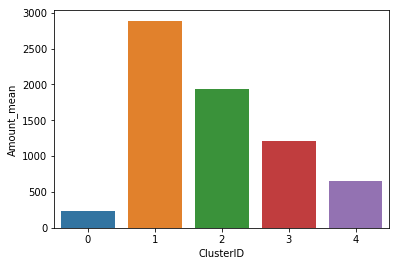

In [39]:
sns.barplot(x=df.ClusterID, y=df.Amount_mean)


Here, each graph has the cluster number on the x axis, whereas the value of Recency, Frequency and Monetary is on the y axis.

 

You found that cluster 5 was the best customer segment from the store’s point of view. These customers make a purchase for a higher amount, more frequently, and these customers had visited the site recently. Thus, the store may offer them a reward or loyalty points or some privileged status, to keep them attracted and coming back to the store.

On the other hand, cluster 3 had the worst customers from the store’s point of view. Thus, the store may decide to focus more on this group. Similarly, in cluster 1, the customers had favourable features in terms of the purchase amount and recency; however, these have low frequency. Thus, if the store can re-design its incentive strategy and entice these customers into making a purchase more frequently, they could turn profitable for the store.

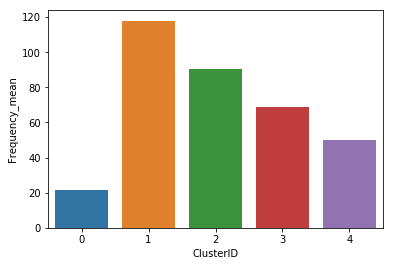

In [40]:
sns.barplot(x=df.ClusterID, y=df.Frequency_mean)

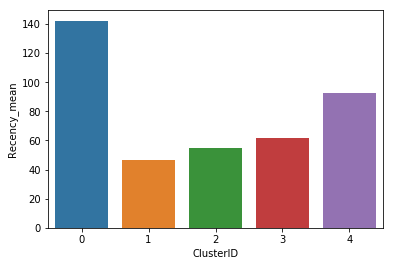

In [41]:
sns.barplot(x=df.ClusterID, y=df.Recency_mean)

So what did you learn in this session?

 

You learnt how to create clusters using the K-means algorithm in Python with the analysis of the Online Store data set. We wanted to group the customers of the store into different clusters based on their purchasing habits. The different steps involved were:

Missing values treatment

Data transformation

Outlier treatment

Data standardisation

Finding the optimal value of K

Implementing K Means algorithm

Analysing the clusters of customers to obtain business insights

 

Once we are through with the data preparation, the K-means algorithm is quite easy to implement. All it takes is running the KMeans() function. The only ambiguous point you may notice here is that you need to decide the number of required clusters beforehand and in fact run the algorithm multiple times with a different number K before you can figure out the most optimal number of clusters.

 

This is also what happens in the industry practices that we run the algorithm multiple times with different values of K and then pick the clusters which make the most business sense. In fact, the k-means algorithm finds large application in the industry. For example, it can be used to find out the most optimal centre to install the mobile towers by clustering the customers geographically. Similarly, it has wide application in medical science, where say the patients can be clustered together on the basis of their symptoms, and then analysed to figure out the cause of their illness.

 

However, K means was just one of the clustering algorithm. In the next session, we will learn about another clustering algorithm called hierarchical clustering, which does not require you to decide the number of clusters beforehand.